# RSNA - EfficientNet Baseline [TF]
_____

### EfficientNet

EfficientNet is one of the most solid baselines known today. It is a family of convolutional neural networks that have achieved state-of-the-art accuracy on ImageNet while also being smaller and faster than other models.
The main idea of EfficientNet is scaling up CNNs in a principled way. It uses a scalable architecture, named compound scaling, which balances network depth, width, and resolution to achieve superior performance.
The image below shows the scaling method in more detail.

![](https://i.ibb.co/Y86KGDg/image4-1.png)

#### Model Size (B5)

As written above, the main claim of efficientnet is providing a method for scaling up neural networks. 
Using this approach, the authors of the paper released the official efficientnet architecture scaled to various sizes [B0, B1, B2.. B7. And two monstrosities L1 and L2].
As it is usually empirically the case (Also hinted by the [Scaling Laws for Neural Language Models](https://arxiv.org/abs/2001.08361)): Performance increase with model size. 
On this notebook we use the **B5** variant of efficientnet. 
Feel free to experiment with larger sizes.

**Installations [Hidden cell]**

In [1]:
# ref : https://www.kaggle.com/adhittio/coba-tf-rsna-efficient-net-baseline/edit

In [2]:
import sys
sys.path.append('../input/kerasapplications')
sys.path.append('../input/efficientnet-keras-source-code/')
import keras_applications
import efficientnet.tfkeras as efficientnet

**Imports [Hidden cell]**

In [3]:
import os
import cv2
import glob
import traceback
import cv2 as cv
import numpy as np
import pandas as pd
from path import Path
from tqdm import tqdm
import nibabel as nib
import pydicom as dicom
import tensorflow as tf
from keras import layers
from pydicom import dcmread
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from pydicom.data import get_testdata_files
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Data Loading

> **Note:** Mean target calculation for a baseline submission.

In [4]:
bad = np.array([['1.2.826.0.1.3680043.10197_C1', '1.2.826.0.1.3680043.10197','C1'],['1.2.826.0.1.3680043.10454_C1', '1.2.826.0.1.3680043.10454','C1'],['1.2.826.0.1.3680043.10690_C1', '1.2.826.0.1.3680043.10690','C1']], dtype=np.object)

train_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
test_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/test.csv")

train_dir = '../input/rsna-2022-cervical-spine-fracture-detection/train_images'
test_dir = '../input/rsna-2022-cervical-spine-fracture-detection/test_images'
first_image = os.path.join(test_dir, test_df['StudyInstanceUID'].iloc[0])

new_submission = []
means = train_df.median(numeric_only=True).to_dict()
means = dict(zip(train_df.columns[1:], np.average(train_df[train_df.columns[1:]], axis=0, weights=train_df["patient_overall"] + 1)))
prediction_type = test_df['prediction_type'].tolist()
submission = pd.read_csv('../input/rsna-2022-cervical-spine-fracture-detection/sample_submission.csv')
for i in range(len(submission)):        
    new_submission.append(means[prediction_type[i]])
submission['fractured'] = new_submission


if(test_df.values[0][0] == bad[0][0]): test_df = pd.DataFrame({"row_id": ['1.2.826.0.1.3680043.22327_C1', '1.2.826.0.1.3680043.25399_C1', '1.2.826.0.1.3680043.5876_C1'], "StudyInstanceUID": ['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876'], "prediction_type": ["C1", "C1", "C1"]})  
prediction_type_mapping = test_df['prediction_type'].map({'C1': 0, 'C2': 1, 'C3': 2, 'C4': 3, 'C5': 4, 'C6': 5, 'C7': 6}).values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


#### Utility Functions & Variables

- **load_dicom:** For loading (and converting) a single dicom image.
- **lisdirs:** For listing the data directory.
- **train_dir / test_dir:** used later on for fast switching between train & validation paths

In [5]:
def load_dicom(path, size = 64):
    try:
        img=dicom.dcmread(path)
        img.PhotometricInterpretation = 'YBR_FULL'
        data=img.pixel_array
        data=data-np.min(data)
        if np.max(data) != 0:
            data=data/np.max(data)
        data=(data*255).astype(np.uint8)        
        return cv2.cvtColor(data.reshape(512, 512), cv2.COLOR_GRAY2RGB)
    except:        
        return np.zeros((512, 512, 3))

def listdirs(folder):
    return [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]    

train_dir = '../input/rsna-2022-cervical-spine-fracture-detection/train_images'
test_dir = '../input/rsna-2022-cervical-spine-fracture-detection/test_images'
patients = sorted(os.listdir(train_dir))

#### Quick Visualizations

> **Credit:** This great [notebook](https://www.kaggle.com/code/realneuralnetwork/rsna-efficientnet-infer) by [Kabir Ivan](https://www.kaggle.com/realneuralnetwork)

Simple sanity test - mainly for testing out the load_dicom function.load_dicom

**Training Samples**

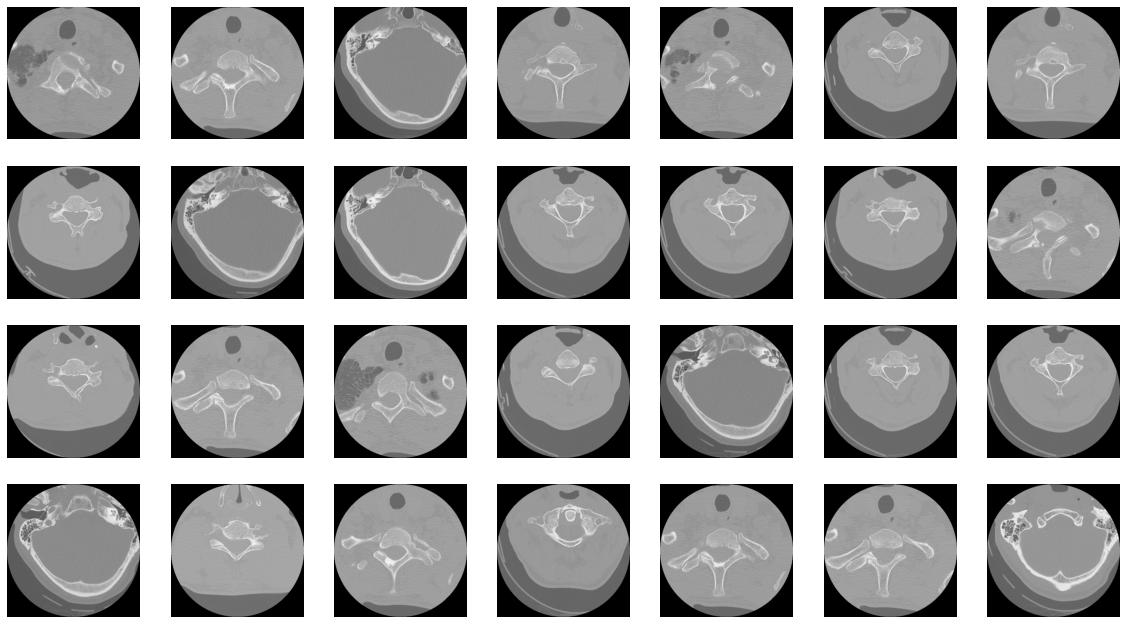

In [6]:
image_file = glob.glob("../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10001/*.dcm")
plt.figure(figsize=(20, 20))

for i in range(28):
    ax = plt.subplot(7, 7, i + 1)
    image_path = image_file[i]
    image = load_dicom(image_path)
    plt.axis('off')   
    plt.imshow(image)

**Targets**

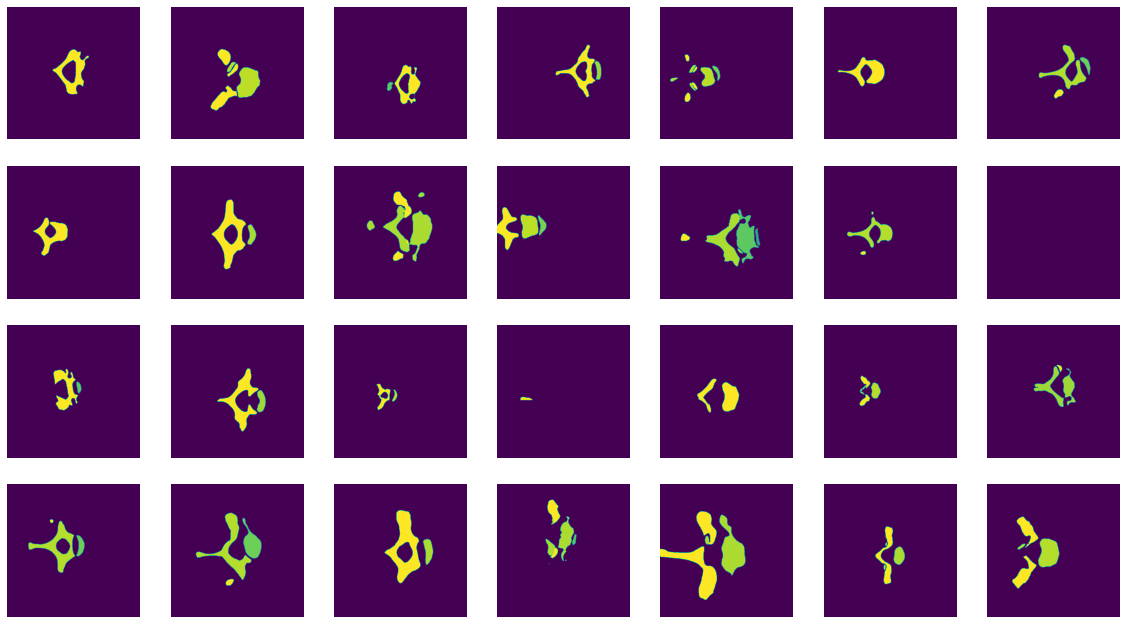

In [7]:
image_file = glob.glob("../input/rsna-2022-cervical-spine-fracture-detection/segmentations/*.nii")
plt.figure(figsize=(20, 20))

for i in range(28):
    ax = plt.subplot(7, 7, i + 1)
    image_path = image_file[i]
    nii_img = nib.load(image_path).get_fdata()
    nib_image = nii_img[:,:,59]
    plt.axis('off')
    plt.imshow(nib_image)

### Data Generators

Since the training data can be a bit large, we load it batch by batch when training & inference.
This is done through simple keras generators. 

#### Train Generator 

- Also yields labels

In [8]:
def RSNATrainGenerator(train_df, batch_size, infinite = True, base_path = train_dir):
    while True:
        trainset = []
        trainidt = []
        trainlabel = []
        for i in (range(len(train_df))):
            idt = train_df.loc[i, 'StudyInstanceUID']
            path = os.path.join(train_dir, idt)
            for im in os.listdir(path):
                dc = dicom.read_file(os.path.join(path,im))
                if dc.file_meta.TransferSyntaxUID.name =='JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])':
                    continue
                img = load_dicom(os.path.join(path , im))
                img = cv.resize(img, (128 , 128))
                image = img_to_array(img)
                image = image / 255.0
                trainset += [image]
                cur_label = []
                cur_label.append(train_df.loc[i,'C1'])
                cur_label.append(train_df.loc[i,'C2'])
                cur_label.append(train_df.loc[i,'C3'])
                cur_label.append(train_df.loc[i,'C4'])
                cur_label.append(train_df.loc[i,'C5'])
                cur_label.append(train_df.loc[i,'C6'])
                cur_label.append(train_df.loc[i,'C7'])
                trainlabel += [cur_label]
                trainidt += [idt]
                if len(trainidt) == batch_size:                    
                    yield np.array(trainset), np.array(trainlabel)
                    trainset, trainlabel, trainidt = [], [], []
            i+=1

#### Test Generator

- Yields only image samples

In [9]:
def RSNATestGenerator(test_df, batch_size, infinite = True, base_path = test_dir):
    while 1:        
        testset=[]
        testidt=[]
        for i in (range(len(test_df))):        
            if type(test_df) is list: idt = test_df[i]
            else: idt = test_df['StudyInstanceUID'].iloc[i]
            path = os.path.join(base_path, idt)
            if os.path.exists(path):
                for im in os.listdir(path):
                    dc = dicom.read_file(os.path.join(path,im))
                    if dc.file_meta.TransferSyntaxUID.name =='JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])':
                        continue
                    img=load_dicom(os.path.join(path,im))
                    img=cv.resize(img,(128, 128))
                    image=img_to_array(img)
                    image=image/255.0
                    testset+=[image]
                    testidt+=[idt]
                    if len(testset) == batch_size:                        
                        yield np.array(testset)
                        testset = []
        if len(testset) > 0: yield np.array(testset)
        if not infinite: break

#### The Model

> **Note:** The training data loads as a single channel image, we use a simple `Conv2D` to align it to be a 3 channel image (As expected by efficientnet).

In [10]:
def get_model():
    inp = keras.layers.Input((None, None ,1))
    x = Conv2D(3, 3, padding = 'SAME')(inp)
    x = efficientnet.EfficientNetB5(include_top=False, weights='../input/efficientnet-weights-for-keras/noisy-student/notop/efficientnet-b5_noisy-student_notop.h5')(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    out = keras.layers.Dense(7, 'sigmoid')(x)
    model = keras.models.Model(inp, out)
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001))
    return model

#### Main Training Cell

We use a stratified (based on patient_overall) KFold split and train 5 different models. 

In [11]:
for train_idx, val_idx in StratifiedKFold(5).split(train_df, train_df['patient_overall']):    
    K.clear_session()
    x_train = train_df.iloc[train_idx].reset_index()
    x_val = train_df.iloc[val_idx].reset_index()
    model = get_model()
    hist = model.fit_generator(                            
                                    RSNATrainGenerator(x_train, min(len(x_train), 64), infinite = False, base_path = train_dir),
                                    epochs = 50,
                                    verbose = 1,
                                    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)],
                                    validation_steps = max((len(x_val) // 64), 1),
                                    steps_per_epoch = max((len(x_train) // 64), 1),
                                    validation_data = RSNATrainGenerator(x_val, min(len(x_val), 64), infinite = False, base_path = train_dir),
                              )
    val_pred = model.predict_generator(RSNATestGenerator(x_val, min(len(test_df), 64), infinite = False, base_path = train_dir), steps = max((len(test_df) // 64), 1))    
    try: # the best we can do at the moment..
        preds = model.predict_generator(RSNATestGenerator(test_df, min(len(test_df), 64), infinite = False, base_path = test_dir), steps = max((len(test_df) // 64), 1))
        
        new_preds = []
        for pred_idx in range(len(preds)):
            new_preds.append(preds[pred_idx][prediction_type_mapping[pred_idx]])
        # submission['fractured'] += preds[:, prediction_type_mapping] / 5
        submission['fractured'] += np.array(new_preds) / 5
        
    except: traceback.print_exc()    

2022-08-25 07:40:31.823700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 07:40:31.938503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 07:40:31.939287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 07:40:31.941233: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 3)     30        
_________________________________________________________________
efficientnet-b5 (Functional) (None, None, None, 2048)  28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 28,527,893
Trainable params: 28,355,157
Non-trainable params: 172,736
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-08-25 07:40:42.492529: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-08-25 07:41:02.735287: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


25/25 [==============================] - 63s 1s/step - loss: 0.4236 - val_loss: 0.4493
Epoch 2/50
25/25 [==============================] - 39s 2s/step - loss: 0.1391 - val_loss: 0.8681
Epoch 3/50
25/25 [==============================] - 32s 1s/step - loss: 0.5976 - val_loss: 0.5658


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 3)     30        
_________________________________________________________________
efficientnet-b5 (Functional) (None, None, None, 2048)  28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 28,527,893
Trainable params: 28,355,157
Non-trainable params: 172,736
_________________________________________________________________
Epoch 1/50
25/25 [==============================] - 43s 929ms/step - loss: 0.6303 - val_loss: 0.3641
Epoch 2/

In [12]:
submission

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.168409
1,1.2.826.0.1.3680043.10454_C1,0.180400
2,1.2.826.0.1.3680043.10690_C1,0.172530


#### Submission

In [13]:
submission.to_csv('submission.csv', index = 0)